# Linear Least Squares

## 03.01 Linear Least Squares

#### Problem: Measurements Have Error
* Measurement errors are inevitable
* Variability can be smoothed out by averaging over more data
* Resulting system is **overdetermined**
  * More equations (rows) than unknowns (columns)

#### Solution: Use Least Squares
* Project higher dimensional data into lower dimensional space
* Suppresses noise and irrelevant detail
* Better written as $Ax \approxeq b$
  * Emphasis that $x$ is not exact solution
* Solution minimizes squared 2-norm of residual
  * $\min_x ||r||_2^2 = \min_x || b - Ax ||_2^2$


What does *linear* mean?
* If $f(t, x)$ is the function represented by $Ax = b$, then coefficients of $A$ are some power of $t$.
$$
f(t, x) = x_1 + x_2 t + x_3 t^2 + ... + x_n t^{n-1}
$$
* Non-linear counterexample.
$$
f(t, x) = x_1 + x_2 e^{t} + x_3 e^{t^2} + ... + x_n e^{t^{n-1}}
$$


Given $m$ data points $(t_i, y_i)$ find n-vector $x$ of parameters that gives best fit to model function $f(t, x)$.

In [1]:
import numpy as np

# Input data $(t_i, y_i)$.
m = 5
t = np.linspace(-1., 1., m)
y = np.array([1., 0.5, 0., 0.5, 2.]).reshape(m, 1)

# Solve Ax = y for x.
A = np.column_stack((np.ones(m), t, t*t))
x, r, _, _ = np.linalg.lstsq(A, y, rcond=None)

# Compute the squared 2-norm of the residual.
resid = y - np.matmul(A, x)
sq2norm = np.linalg.norm(resid, ord=2)**2

# Compare to the residual returned from np.linalg.lstsq.
np.testing.assert_almost_equal(sq2norm, r)

Plot the observations against the fit.

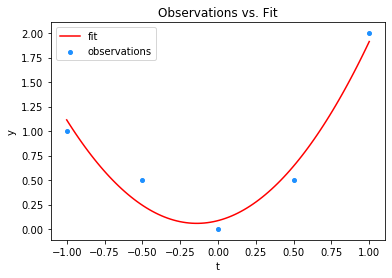

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

# Fit the model to a dense 1D-grid of points from [-1, 1].
fitn = m*20
fitx = np.linspace(-1, 1, fitn)
fitA = np.column_stack((np.ones(fitn), fitx, fitx*fitx))
fity = np.matmul(fitA, x)

# Plot the fitted model against observations.
plt.scatter(t, y, s=16, c='dodgerblue', label='observations')
plt.plot(fitx, fity, c='red', label='fit')
plt.title('Observations vs. Fit')
plt.ylabel('y')
plt.xlabel('t')
plt.legend(loc=0)  # Upper left corner.
plt.show()

## 03.02 Existence, Uniqueness, and Conditioning

* Linear least squares problem $Ax \approxeq b$ **always** has solution.
* Solution unique IFF columns are linearly independent aka $\text{rank}(A) = n$ where $A$ is $m \times n$.

#### Derivation
* To minimize the squared 2-norm of residual we need to find the derivative and set to 0.
$$
\begin{aligned}
||r||_2^2 &= r^T r \\
&= (b - Ax)^T (b - Ax) \\
&= b^T b - 2 x^T A^T b + x^T A^T A x \\
\end{aligned}
$$

* The gradient of $||r||_2^2$ set equal to 0 is aka **normal equations**.
$$
\begin{aligned}
\nabla(||r||_2^2) &= 0 \\
2 A^T A x - 2 A^T b &= 0 \\
A^T A x &= A^T b 
\end{aligned}
$$

* Since $A^TA$ is square, we can use the techniques for solving systems of linear equations to solve linear least squares problems.

#### Orthogonality
* $v_1$ and $v_2$ are othogonal when $v_1^T v_2 = 0$.
* Value of $y = Ax$ closest to solution $b$ occurs when residual $r = b - Ax$ is orthogonal to $\text{span}(A)$.
  * Project higher dimensional data $b$ ($m \times 1$) into lower dimensional space $\text{span}(A)$ (space spanned by columns $n$).
* Angle between $y = Ax$ and $b$ computed as:
  * $\text{cos}(\theta) = \frac{||y||_2}{||b||_2}$


#### Orthogonal Projectors
* $P$ is an orthgonal projector when:
  * $P^2 = P$ aka idempotent
  * $P^T = P$ aka symmetric
* We can decompose any vector $v$ into 2 components:
  * Component in $\text{span}(P)$
  * Component in $\text{span}(P)^{\perp}$ aka orthogonal to $P$
* For least squares $P$ is an orthogonal projector onto $\text{span}(A)$.
  * $P = A (A^T A)^{-1} A^T$

#### Pseudoinverse
* If $A$ is $m \times n$ and $\text{rank}(A) = n$, then pseudoinverse is defined as the inverse of the product of the matrix and its' transpose.
  * $A^{+} = (A^T A)^{-1} A^T$
* Condition number of $A$ defined using pseudoinverse:
  * $\text{cond}(A) = ||A||_2 \cdot ||A^{+}||_2$
* The angle between $y = Ax$ and $b$ also bounds the relative error:
  * $\frac{||\Delta{x}||}{||x||} \leq \text{cond}(A) \frac{1}{\text{cos}(\theta)} \frac{||\Delta{b}||}{||b||}$
  * When the angle $\theta$ is small, then $\theta \approxeq 0$ and value of $\text{cos}(\theta) \approxeq 1$.  As a result, relative error will be small.
  * When the angle $\theta$ is big, then relative error will be large.

## 03.03 Solving Linear Least Squares Problems

#### Normal Equations Method
* If $A$ has rank $n$ then symmetric matrix $A^TA$ is positive definite.
* Use cholesky factorization solve $Ax = b$ for $x$.
  1. Premultiply both sides by $A^T$ to obtain $A^T A x = A^T b$.
  2. Factorize $A^T A$ into $L L^T$ to obtain $L L^T x = A^T b$.
  3. Solve $L z = A^Tb$ for $z$ using forward substitution.
  4. Solve $L^T x = z$ for $x$ using back substitution.
* This technique has problems in finite precision arithmetic.
  * Computing $A^TA$ introduces roundoff.
  * Sensitivity of solution is worsened.
    * $\text{cond}(A^T A) = [\text{cond}(A)]^2$
  * Normal equations method is **unstable** due to these introduced computational errors.

Solve $Ax = b$ for $x$ where $A$ is $m \times n$ using cholesky factorization.

In [3]:
import math
import numpy as np
import scipy.linalg as la

# Input data $(t_i, b_i)$.
m = 5
t = np.linspace(-1., 1., m)
b = np.array([1., 0.5, 0., 0.5, 2.]).reshape(m, 1)
A = np.column_stack((np.ones(m), t, t*t))

# Premultiply the left and right hand side by A^T.
ATA = np.matmul(A.T, A)
ATb = np.matmul(A.T, b)

# Factorize A^T A into L L^T.
LLT = np.linalg.cholesky(ATA)

# Solve Lz = A^Tb for z using forward substitution.
z = la.solve_triangular(LLT, ATb, lower=True, unit_diagonal=False)

# Solve L^Tx = z for x using back substitution.
x = la.solve_triangular(LLT.T, z, lower=False, unit_diagonal=False)

# Compute the squared 2-norm of the residual.
resid = y - np.matmul(A, x)
sq2norm = np.linalg.norm(resid, ord=2)**2

# Compare to the residual returned from np.linalg.lstsq.
_, r, _, _ = np.linalg.lstsq(A, b, rcond=None)
np.testing.assert_almost_equal(sq2norm, r)

## 03.04 Orthogonalization Methods

* Matrix $Q$ is orthogonal if $Q^T Q = I$.
* Columns of orthogonal matrix are orthonormal eg orthogonal unit vectors.
* Multiplying vector by orthogonal matrix does not change its' 2-norm.
  * $||Qv||_2^2 = ||v||_2^2$
* Use orthogonalization method to solve $Ax = b$ for $x$.
  * More computationally expensive than elimination.
  * More numerically stable than normal equations method.
  
#### QR Factorization
Given $m \times n$ matrix $A$ find an $m \times m$ matrix $Q$.
$$
A = Q
\begin{bmatrix}
R \\
0
\end{bmatrix}
$$
where
  * Q is an $m \times m$ orthogonal matrix
  * R is an $n \times n$ upper triangular matrix
  * 0 is an $(m-n) \times n$ zero matrix

To compute QR factorization of $A$ use one of orthogonal transformations below.
  * Householder transformations
  * Givens rotations
  * Gram-Schmidt orthogonalization

Solve $Ax = b$ for $x$ where $A$ is $m \times n$ using QR factorization via scipy.

In [4]:
import numpy as np
import scipy.linalg as la

# Input data $(t_i, b_i)$.
m = 5
t = np.linspace(-1., 1., m)
b = np.array([1., 0.5, 0., 0.5, 2.]).reshape(m, 1)
A = np.column_stack((np.ones(m), t, t*t))
n = A.shape[1]

# Factorize A into [R/0].
Q, R = np.linalg.qr(A)

# Apply the same transformations to b.
c = np.matmul(Q.T, b)

# Solve Rx = c for x by back substitution.
# NOTE(mmorais): Both R and c must be square.
x = la.solve_triangular(R[:n,:], c[:n], lower=False, unit_diagonal=False)

# Compute the squared 2-norm of the residual.
resid = y - np.matmul(A, x)
sq2norm = np.linalg.norm(resid, ord=2)**2

# Compare to the residual returned from np.linalg.lstsq.
_, r, _, _ = np.linalg.lstsq(A, b, rcond=None)
np.testing.assert_almost_equal(sq2norm, r)

## 03.05 Householder QR Factorization

Householder transformation of the vector $v$
$$
H = I - 2 \frac{v v^T}{v^T v}
$$
where
* H is orthogonal ($H^T H = I$) and symmetric ($H^T = H$)

Given some vector $a$ choose $v$ as:
$$
v = a - \alpha e_1
$$
where
* $\alpha = \pm ||a||_2$ with sign chosen to avoid cancellation
* $e_1$ is the standard basis vector of the form $[1 \quad 0 \cdots 0]^T$

The householder transform of the vector $a$ is $Ha$ computed as:
$$
Ha = a - 2 \frac{v^T a}{v^T v} v
$$

The householder transform of the vector $a$ will zero out all but 1 element.

Perform a Householder transformation on vector a.

In [5]:
import numpy as np

a = np.array([2., 1., 2.]).reshape(3, 1)

# Compute v = a - \alpha e_1.
alpha = np.linalg.norm(a, ord=2)
alpha = -1. * alpha if np.sign(alpha) == 1 else alpha
e_1 = np.zeros((a.size, 1))
e_1[0] = 1.
v = a - alpha * e_1

# Compute H = I - 2 ((vv^T) / (v^Tv)).
H = np.eye(a.size) - 2. * (np.dot(v, v.T)/np.dot(v.T, v))

# Confirm that H is orthogonal.
np.testing.assert_almost_equal(np.matmul(H.T, H), np.eye(a.size))

# Confirm that H is symmetric.
np.testing.assert_almost_equal(H.T, H)

# Compute householder transform Ha and compare to explict Ha.
Ha = a - 2. * (np.dot(v.T, a)/np.dot(v.T, v)) * v
np.testing.assert_almost_equal(Ha, np.matmul(H, a))

#### Linear Least Squares Using Householder QR Factorization
1. Use Householder transforms to annihilate subdiagonal entries of each successive column.
$$
H_n \cdots H_1 A = Q^T A =
\begin{bmatrix}
R \\
0
\end{bmatrix}
$$
  * Use the formula for $Ha$ to compute the *ith* transform rather than matrix multiplication.
2. Apply the same set of transformations to right hand side $b$.
$$
H_n \cdots H_1 b = Q^T b
$$
3. Solve for $x$ using backsubstitution.
$$
\begin{bmatrix}
R \\
0
\end{bmatrix}
x \approxeq Q^T b
$$


Solve $Ax = b$ for $x$ where $A$ is $m \times n$ using householder QR factorization.

In [6]:
import numpy as np
import scipy.linalg as la

def householder_qr(A):
    """
    Use householder transformations to factorize A into [R/0].
    
    Return the householder vectors in the matrix Q.
    """
    Q = np.zeros(A.shape)
    for k in range(A.shape[1]):  # Columns.
        alpha_k = -1. * np.sign(A[k,k]) * np.linalg.norm(A[k:,k], ord=2)
        e_k = np.zeros((A.shape[0], 1))
        e_k[k] = 1.
        a_k = np.concatenate((e_k[:k], A[k:,k,np.newaxis]))
        v_k = a_k - alpha_k * e_k
        Q[:,k,np.newaxis] = v_k
        beta_k = np.dot(v_k.T, v_k)
        if abs(beta_k) < np.finfo('d').eps:
            continue
        for j in range(k, A.shape[1]):  # Columns.
            gamma_j = np.dot(v_k.T, A[:,j])
            A[:,j,np.newaxis] -= (2.*gamma_j/beta_k) * v_k
    return Q, A


def householder_mult(Q, b):
    """
    Multiply the householder vectors from Q with the matrix b.
    """
    for k in range(Q.shape[1]):
        v = Q[:,k,np.newaxis]
        b -= 2. * (np.dot(v.T, b)/np.dot(v.T, v)) * v
    return b


# Input data $(t_i, b_i)$.
m = 5
t = np.linspace(-1., 1., m)
b = np.array([1., 0.5, 0., 0.5, 2.]).reshape(m, 1)
A = np.column_stack((np.ones(m), t, t*t))
n = A.shape[1]

# Factorize A into [R/0].
Q, R = householder_qr(np.copy(A))

# Apply the householder transformation to b.
c = householder_mult(Q, np.copy(b))

# Solve Rx = c for x by back substitution.
# NOTE(mmorais): Both R and c must be square.
x = la.solve_triangular(R[:n,:], c[:n], lower=False, unit_diagonal=False)
 
# Compute the squared 2-norm of the residual.
resid = y - np.matmul(A, x)
sq2norm = np.linalg.norm(resid, ord=2)**2

# Compare to the residual returned from np.linalg.lstsq.
_, r, _, _ = np.linalg.lstsq(A, b, rcond=None)
np.testing.assert_almost_equal(sq2norm, r)

## 03.06 Givens QR Factorization

## 03.07 Gram-Schmidt QR Factorization

## 03.08 Rank Deficiency

## 03.09 Singular Value Decomposition

## 03.10 Comparison of Methods for Least Squares